In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/home/prasoon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
df = pd.read_csv("Desktop/train (4).csv")



In [9]:
X_train_orig = np.array(df.loc[:,'pixel0':]).reshape(42000,28,28)

In [10]:
Y_train_orig=np.array(df.loc[:,['label']]).reshape(42000,1)

y = 5


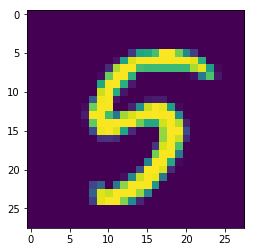

In [11]:
index = 8
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[index])))

In [12]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T
#Y_train_flatten = Y_train_orig.reshape(Y_train_orig.shape[0],-1).T

In [13]:
X_train_flatten_new = X_train_flatten[:,0:33600]
X_test_flatten_new = X_train_flatten[:,33600:42000]
Y_train_flatten_new = Y_train_orig[0:33600,:]
Y_test_flatten_new = Y_train_orig[33600:42000,:]

In [14]:
X_train = X_train_flatten_new/255
X_test = X_test_flatten_new/255

In [15]:
Y_train = tf.Session().run(tf.one_hot(Y_train_flatten_new,10,axis=1)).reshape(33600,10).T
Y_test = tf.Session().run(tf.one_hot(Y_test_flatten_new,10,axis=1)).reshape(8400,10).T

In [16]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,shape=[n_y,None],name='Y')
    return X,Y

In [17]:
def initialize_parameters(layers_dims):
    parameters={}
    for l in range(len(layers_dims)-1):
        parameters["W"+str(l+1)] = tf.get_variable('W'+str(l+1),[layers_dims[l+1],layers_dims[l]],initializer = tf.contrib.layers.xavier_initializer())
        parameters["b"+str(l+1)] = tf.get_variable("b"+str(l+1),[layers_dims[l+1],1],initializer = tf.zeros_initializer())
    return parameters

In [18]:
def forward_propagation(X,parameters,layers_dims):
    cache = {}
    cache["A0"] = X
    for l in range(len(layers_dims)-1):
        cache["Z"+str(l+1)] = tf.add(tf.matmul(parameters["W"+str(l+1)],cache["A"+str(l)]),parameters["b"+str(l+1)])
        if (l == len(layers_dims)-2):
            return cache["Z"+str(l+1)]
        cache["A"+str(l+1)] = tf.nn.relu(cache["Z"+str(l+1)])
        

In [20]:
def compute_cost(ZL,Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = tf.transpose(ZL), labels = tf.transpose(Y)))
    return cost

In [55]:
def random_minibatch(X_train,Y_train,minibatch_size,num_minibatches):
    minibatches = []
    random_shuffle = np.concatenate((X_train.T,Y_train.T),axis=1)
    np.random.shuffle(random_shuffle)
    random_shuffle_X = random_shuffle[:,0:X_train.shape[0]].T
    random_shuffle_Y = random_shuffle[:,X_train.shape[0]:X_train.shape[0]+Y_train.shape[0]].T
    for i in range(num_minibatches):
        minibatch_X = random_shuffle_X[:,i*minibatch_size:minibatch_size*(i+1)]
        minibatch_Y = random_shuffle_Y[:,i*minibatch_size:minibatch_size*(i+1)]
        minibatch = (minibatch_X,minibatch_Y)
        minibatches.append(minibatch)
    if (Y_train.shape[1]/num_minibatches != 0):
        minibatch_X = random_shuffle_X[:,num_minibatches*minibatch_size:X_train.shape[1]]
        minibatch_Y = random_shuffle_Y[:,num_minibatches*minibatch_size:Y_train.shape[1]]
        minibatch = (minibatch_X,minibatch_Y)
        minibatches.append(minibatch)
    return minibatches

In [56]:
def l2_regularize(unreg_cost,parameters,layers_dims,m):
    reg_fac = 0
    for l in range(len(layers_dims)-1):
        reg_fac = reg_fac + 0.01 * tf.nn.l2_loss(parameters["W"+str(l+1)])
    cost = unreg_cost+reg_fac
    return cost
    

In [57]:
def model(X_train,Y_train,X_test,Y_test,learning_rate,num_epochs,minibatch_size,print_cost,layers_dims):
    tf.reset_default_graph()
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs =[]
    X,Y = create_placeholders(n_x,n_y)
    parameters = initialize_parameters(layers_dims)
    ZL = forward_propagation(X,parameters,layers_dims)
    unreg_cost = compute_cost(ZL,Y)
    cost = l2_regularize(unreg_cost,parameters,layers_dims,m)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    num_minibatches = int(m/minibatch_size)
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            minibatches = random_minibatch(X_train,Y_train,minibatch_size,num_minibatches)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                _,minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                epoch_cost = epoch_cost + minibatch_cost/num_minibatches
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
                
            
            

Cost after epoch 0: 2.526463
Cost after epoch 100: 1.585008
Cost after epoch 200: 1.436792
Cost after epoch 300: 1.368883
Cost after epoch 400: 1.322020
Cost after epoch 500: 1.297692
Cost after epoch 600: 1.281570
Cost after epoch 700: 1.274348
Cost after epoch 800: 1.251553
Cost after epoch 900: 1.249599
Cost after epoch 1000: 1.235118
Cost after epoch 1100: 1.231654
Cost after epoch 1200: 1.219114
Cost after epoch 1300: 1.216816
Cost after epoch 1400: 1.204898


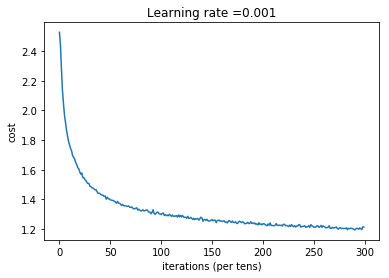

Train Accuracy: 0.75375
Test Accuracy: 0.55


In [58]:
model(a,b,c,d,0.001,1500,64,True,[X_train.shape[0],2,10])

In [49]:
a = X_train[:,0:800]
b = Y_train[:,0:800]

In [50]:
c = X_test[:,0:100]
d = Y_test[:,0:100]